In [1]:
import powerlaw
import networkx as nx
import pandas as pd
from tqdm import tqdm
from glob import glob
import csv
import networkx as nx
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
import re
import statsmodels.formula.api as smf
from collections import Counter
import ast

/home/xjgong/anaconda3/envs/narrative/lib/python3.11/site-packages/networkx/utils/backends.py:119: RuntimeWarning: Error encountered when loading info for backend cugraph: No module named '_nx_cugraph'
  backend_info.update(_get_backends("networkx.backend_info", load_and_call=True))


In [2]:
def proc(filename):
    with open(filename) as file:
        data=json.load(file)
    return data
    
def create_character_data(data, printTop):
    character_data = []
    
    for character in data["characters"]:
    
        agentList=" ".join([i["w"].lower() for i in character["agent"]])
        patientList=" ".join([i["w"].lower() for i in character["patient"]])
        modList=" ".join([i["w"] for i in character["mod"] if len(character["mod"]) > 0])
    
        character_id=character["id"]
        count=character["count"]
    
        referential_gender_distribution=referential_gender_prediction="unknown"
    
        if character["g"] is not None and character["g"] != "unknown":
            referential_gender_distribution=character["g"]["inference"]
            referential_gender=character["g"]["argmax"]
    
        mentions=character["mentions"]
        proper_mentions=mentions["proper"]
        max_proper_mention=""
        role = ""
        if len(proper_mentions) > 0:
            max_proper_mention = mentions["proper"][0]["n"]
            role = "proper"
        elif len(mentions["common"]) > 0:
            max_proper_mention = mentions["common"][0]["n"]
            role = "common"
            
    
        temp={"id": character["id"],
         "name": max_proper_mention,
        "gender": referential_gender,
        "mod": modList,
              "agent_list": agentList,
              "patient_list": patientList,
        "count": count,
             "role": role}    
    
        character_data.append(temp)
    
    character_data = pd.DataFrame(character_data)
    character_data = character_data[character_data["count"] >= printTop]
    return character_data

def get_event_character_df(book, data_root):
    count_threshold = 1
    
    book_file = "{}/{}/{}.book".format(data_root, book,book)
    data = proc(book_file)
    
    token_file = "{}/{}/{}.tokens".format(data_root, book,book)
    token_df = pd.read_csv(token_file, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
    events_df = token_df.copy()
    
    patient_df = []
    for cha in data["characters"]:
        for i in cha["patient"]:
            cha_patient_temp = {"patient": cha["id"],
                                "event": i["w"],
                                "event_id": i["i"]}
            patient_df.append(cha_patient_temp)
        
    patient_df = pd.DataFrame(patient_df)
    
    agent_df = []
    for cha in data["characters"]:
        for i in cha["agent"]:
            cha_agent_temp = {"agent": cha["id"],
                                "event": i["w"],
                                "event_id": i["i"]}
            agent_df.append(cha_agent_temp)
    
    agent_df = pd.DataFrame(agent_df)

    
    events_df = events_df.merge(patient_df[["event_id", "patient"]], how="left", left_on="token_ID_within_document", right_on="event_id")
    events_df = events_df.merge(agent_df[["event_id", "agent"]], how="left", left_on="token_ID_within_document", right_on="event_id")
    events_df = events_df[~events_df[["agent", "patient"]].isnull().any(axis=1)]
    events_df = events_df.drop(["event_id_x", "event_id_y"], axis=1)
    events_df = events_df[~(events_df.agent == events_df.patient)] # filter out events that agent and patient are the same

    character_data = create_character_data(data, count_threshold)
    character_data = character_data[~(character_data.name=='')] # filter out characters that do not have a name

    events_df = events_df.merge(character_data[["id", "name"]].add_prefix('agent_'), how="left", left_on="agent", right_on="agent_id")
    events_df = events_df.merge(character_data[["id", "name"]].add_prefix('patient_'), how="left", left_on="patient", right_on="patient_id")
    events_df = events_df.dropna(subset=["agent_name", "patient_name"])
    
    character_data_new = character_data.drop_duplicates(subset=["name"], keep="first").reset_index(drop=True)

    character_data_new["mod"] = character_data_new["name"].map(character_data.groupby("name")["mod"].apply(list).apply(lambda x: " ".join(x)))
    character_data_new["agent_list"] = character_data_new["name"].map(character_data.groupby("name")["agent_list"].apply(list).apply(lambda x: " ".join(x)))
    character_data_new["patient_list"] = character_data_new["name"].map(character_data.groupby("name")["patient_list"].apply(list).apply(lambda x: " ".join(x)))

    return character_data_new, events_df, token_df

In [3]:
def get_network_metrics(G):
    Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
    G0 = G.to_undirected().subgraph(Gcc[0])
    
    n_nodes = G0.number_of_nodes()
    n_edges = G0.number_of_edges()
    
    if n_nodes > 1 and n_edges > 1:
        
        average_clustering = nx.average_clustering(G0, weight="weight")
        communities = nx.community.louvain_communities(G0, weight="weight")
        modularity = nx.community.modularity(G0,communities, weight="weight" )
        network_density = nx.density(G0)
        average_shortest_path_largest_component = nx.average_shortest_path_length(G0, weight=None)

            

        network_metrics = {"n_nodes": n_nodes,
                      "network_density": network_density,
                      "average_clustering": average_clustering,
                      "modularity": modularity,
                      "average_shortest_path_largest_component": average_shortest_path_largest_component}

    else:
        network_metrics = {"n_nodes": n_nodes,
                      "network_density": np.nan,
                      "average_clustering": np.nan,
                      "modularity": np.nan,
                      "average_shortest_path_largest_component": np.nan}

    return network_metrics

In [35]:
meta_df = pd.read_csv("../../movie_script/meta_df_with_imdb.csv")

In [5]:
events_df_dict = {}
characters_df_dict = {}
token_df_df_dict = {}
for book in tqdm(meta_df.title.tolist()):
    try:
        character_data, events_df, token_df = get_event_character_df(book, "../../movie_script/book_nlp_output_new")
        events_df_dict[book] = events_df
        characters_df_dict[book] = character_data
    except:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1266/1266 [00:20<00:00, 63.28it/s]


In [6]:
from collections import Counter
networks_dict = {}
for book in tqdm(meta_df.title.tolist()):
    try:
        events_df = events_df_dict[book]
        character_data = characters_df_dict[book]
    
        events_df = events_df[(events_df.agent_name.isin(character_data.name.unique()))&(events_df.patient_name.isin(character_data.name.unique()))]
        events_df = events_df[~(events_df.agent_name==events_df.patient_name)]

        edge_list = events_df[["agent_name", "patient_name", "lemma"]]

        if edge_list.shape[0] >= 10:
            G_multi = nx.from_pandas_edgelist(edge_list, source="agent_name", target="patient_name", edge_attr=["lemma"], create_using=nx.MultiGraph).to_undirected()
            edge_counts = Counter((min(u, v), max(u, v)) for u, v in G_multi.edges())
            
            G = nx.Graph()
            G.add_edges_from((u, v, {'weight': w}) for (u, v), w in edge_counts.items())
            
            networks_dict[book] = G
        
    except:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1266/1266 [00:01<00:00, 1195.06it/s]


In [7]:
network_metrics_dict = {}
for book in tqdm(networks_dict.keys()):
    G0 = networks_dict[book]
    if G0.number_of_nodes() > 2:
        network_metrics = get_network_metrics(networks_dict[book])
        network_metrics_dict[book] = network_metrics
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1124/1124 [00:02<00:00, 478.40it/s]


In [8]:
network_metric_df = pd.DataFrame(network_metrics_dict).T.reset_index()

In [9]:
for col in network_metric_df.columns:
    try:
        network_metric_df[col] = network_metric_df[col].astype(float)
    except:
        pass

In [10]:
meta_df_all = meta_df.merge(network_metric_df, how="left", left_on="title", right_on="index")

In [11]:
for col in meta_df_all.columns:
    try:
        meta_df_all[col] = meta_df_all[col].astype(float)
    except:
        pass

In [12]:
meta_df_all["genres"] = meta_df_all["genres"].apply(ast.literal_eval)

genres = ['Drama', 'Thriller','Comedy','Action','Crime','Romance', 'Adventure',
 'Sci-Fi','Horror','Mystery','Fantasy','Family','Animation','War','Musical','Western']

for genre in genres:
    meta_df_all[f"genre_{genre}"] = meta_df_all["genres"].apply(lambda x: int(genre in x if isinstance(x, list) else False))

meta_df_all.rename(
    columns={f"genre_{g}": f"genre_{g.lower().replace('-', '').replace('sci fi', 'scifi')}" for g in [
        'Drama', 'Thriller', 'Comedy', 'Action', 'Crime', 'Romance', 'Adventure',
        'Sci-Fi', 'Horror', 'Mystery', 'Fantasy', 'Family', 'Animation',
        'War', 'Musical', 'Western'
    ]},
    inplace=True
)
genres = ['drama', 'thriller','comedy','action','crime','romance',
 'scifi','horror','mystery','fantasy','family','animation','war','musical','western']

In [13]:
meta_df_all["runtimeMinutes"] = pd.to_numeric(meta_df_all['runtimeMinutes'], errors='coerce')

In [14]:
meta_df_all = meta_df_all[~meta_df_all.averageRating.isna()]

In [15]:
meta_df_all = meta_df_all[~meta_df_all.imdb_id_final.isna()]

In [16]:
from scipy import stats

meta_df_all = meta_df_all.dropna(subset=["n_nodes",  "network_density", "average_clustering", "modularity",
              "average_shortest_path_largest_component", "startYear", "isAdult", "runtimeMinutes"])

In [17]:
meta_df_all[["n_nodes",  "network_density", "average_clustering", "modularity",
              "average_shortest_path_largest_component"]].describe()

,n_nodes,network_density,average_clustering,modularity,average_shortest_path_largest_component
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,22.185688,0.141241,0.039580,0.260034,2.452183
std,11.173442,0.079923,0.039352,0.138702,0.403130
min,3.000000,0.029989,0.000000,0.000000,1.333333
25%,14.000000,0.088319,0.015100,0.160697,2.176309
50%,20.000000,0.121212,0.030154,0.262056,2.410771
75%,28.000000,0.169322,0.051767,0.356273,2.672687
max,97.000000,0.666667,0.500000,0.686634,4.608819


In [33]:
meta_df_all.isAdult.value_counts()

isAdult
0.0    1104
Name: count, dtype: int64

In [18]:
for col in meta_df_all.columns:
    try:
        meta_df_all.loc[:,col] = meta_df_all[col].astype(float)
    except:
        pass

In [19]:
meta_df_all["runtimeMinutes"] = pd.to_numeric(meta_df_all.runtimeMinutes, errors="coerce")
meta_df_all["startYear"] = pd.to_numeric(meta_df_all.startYear, errors="coerce")

<Axes: >

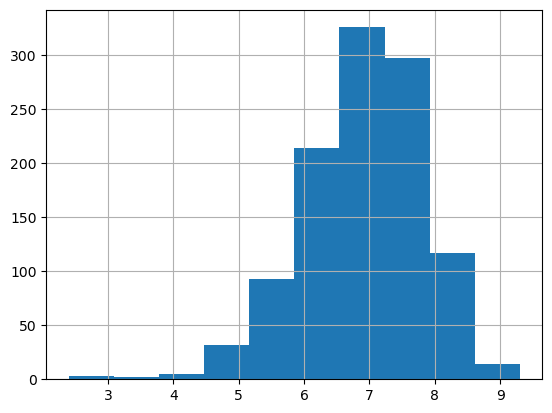

In [20]:
meta_df_all.averageRating.hist()

In [21]:
meta_df_all = meta_df_all[~meta_df_all.averageRating.isna()]

<Axes: >

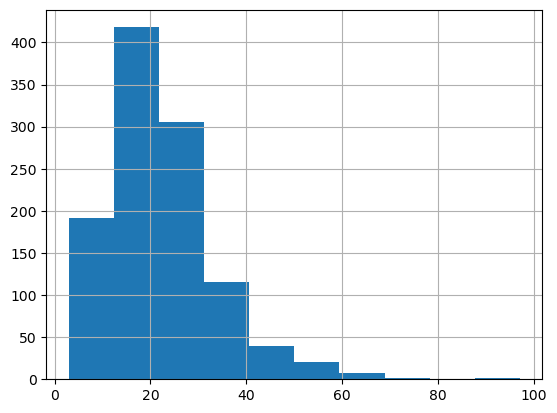

In [22]:
meta_df_all.n_nodes.hist()

In [28]:
meta_df_all.columns

Index(['Unnamed: 0', 'imdb_id_final', 'title', 'primaryTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'url',
       'index', 'n_nodes', 'network_density', 'average_clustering',
       'modularity', 'average_shortest_path_largest_component', 'genre_drama',
       'genre_thriller', 'genre_comedy', 'genre_action', 'genre_crime',
       'genre_romance', 'genre_adventure', 'genre_scifi', 'genre_horror',
       'genre_mystery', 'genre_fantasy', 'genre_family', 'genre_animation',
       'genre_war', 'genre_musical', 'genre_western'],
      dtype='object')

In [31]:
meta_df_all[['imdb_id_final', 'title', 'primaryTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'url',
       'n_nodes', 'network_density', 'average_clustering',
       'modularity', 'average_shortest_path_largest_component', 'genre_drama',
       'genre_thriller', 'genre_comedy', 'genre_action', 'genre_crime',
       'genre_romance', 'genre_adventure', 'genre_scifi', 'genre_horror',
       'genre_mystery', 'genre_fantasy', 'genre_family', 'genre_animation',
       'genre_war', 'genre_musical', 'genre_western']].to_csv("../data/study2_movie/movie_regression_df.csv", index=False)